In [14]:
import pandas as pd
import re
import os
import nltk
import spacy
import string
import matplotlib.pyplot as plt
from nltk import word_tokenize
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

nlp = spacy.load("en_core_web_sm")
nltk.download('universal_tagset')
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Я решил работать с датасетами диалогов в надежде, что они дадут информацию о структурах сообщений-планов. 
Нам надо из сообщений, где есть даты\вермя выделить именно те, которые говорят о плане задаче или о событии. Вероятнее всего надо попробовать прокластеризировать сообщения, так как вручную разметить десятки тысяч сообщений не вариант. Когда будет размеченный датасет, можно попробовать построить классификатор)

Сначала сделаем алгоритм, который ищет токен времени и соотносящийся к нему ROOT токен с помощью spacy. Строка из датасета multiwoz.ipynb

In [2]:
docs = ["Boss is planning a vacation tomorrow night and really could use some help finding a good place to stay in town.",
        "I`m going to stay here 2 for 5 nights starting Sunday",
        "I need to arrive at 13:45",
        "I need the travel day to be Sunday",
        "I'll be going to Cambridge and arrive by 13:45", 
        "Train TR7468 will arrive at 13:23.",
        "Bears wake up at spring"]

In [3]:
tags = []
doc = nlp(docs[0])
for token in doc:
    tags.append([token.text, token.lemma_, token.ent_type_, token.pos_, token.tag_, token.dep_, token.head])
postok = {str(i): list(doc).index(i) for i in doc}
pd.DataFrame(tags, columns = ["Token", "lemma", "entity", "full", "entity", "dep type", "head"])

,Token,lemma,entity,full,entity,dep type,head
0,Boss,boss,,NOUN,NN,nsubj,planning
1,is,be,,AUX,VBZ,aux,planning
2,planning,plan,,VERB,VBG,ROOT,planning
3,a,a,,DET,DT,det,vacation
4,vacation,vacation,,NOUN,NN,dobj,planning
5,tomorrow,tomorrow,DATE,NOUN,NN,compound,night
6,night,night,,NOUN,NN,npadvmod,planning
7,and,and,,CCONJ,CC,cc,planning
8,really,really,,ADV,RB,advmod,use
9,could,could,,AUX,MD,aux,use


In [4]:
displacy.render(doc, jupyter=True)

Я хочу развернуть полное предложение - ивент, от времени до главного слова фразы

In [5]:
tok = doc[postok["tomorrow"]] #Time token
tok_seq = []
token_head = tok
while True:
    filtered_tok_seq = [] # filter extra dependencies of root word
    head_tok_seq = [*[i for i in token_head.lefts if i not in tok_seq], token_head, *[i for i in token_head.rights if i not in tok_seq]]
    for j in range(len(head_tok_seq)):
        if (head_tok_seq[j].dep_ in ["dobj", "nsubj", "ROOT"]) or (head_tok_seq[j] is token_head):
            filtered_tok_seq.append(head_tok_seq[j])
    tok_seq.extend(filtered_tok_seq)
    if (token_head.dep_ == "ROOT"):
        break
    token_head = token_head.head
tok_seq

[tomorrow, night, Boss, planning, vacation]

Получили из токена времени tomorrow полное предложение - Boss, planning, vacation, tomorrow, night

## Representatoins of messages
 В начале посмотрим на датасет с сообщениями, собранный из источников:

In [10]:
df = pd.DataFrame()
if (not os.path.exists("../processed_data/data.csv")):
    df = pd.DataFrame()
    for frame in os.listdir("../processed_data"):
        df_temp = pd.read_csv(f"../processed_data/{frame}", index_col=0)
        df = pd.concat([df, df_temp])
        del df_temp
    df = df.iloc[:, :-1]
    df.to_csv("../processed_data/data.csv")
else:
    df = pd.read_csv("../processed_data/data.csv", index_col=0)
df.head()

/tmp/ipykernel_1777/491176699.py:11: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../processed_data/data.csv", index_col=0)


,text,root,event,label
0,Did you know that the University of Iowa 's lo...,NaN,NaN,0.0
1,I think I did hear something about that . I ...,NaN,NaN,0.0
2,"So , it would be in the visiting team 's locke...",NaN,NaN,0.0
3,Right . Teams do all kinds of things to both...,heard,in teams winter benches of I heated heard,1.0
4,"I would hate a cold bench . Then again , I wou...",NaN,NaN,0.0


In [27]:
print(f"{df.shape[0]} - количество записей в датасете")

(1798937, 4)

In [29]:
print(f"{df[df["label"] == 1].shape[0]} - количество записей с указателями даты или времени")

(171740, 4)

Получили из 4 источников 1798937 сообщений и 171740 собщений с датами. Можем продолжать с этим работать

### Preprocessing and TfIdf


In [11]:
def prepare_text(input: str) -> list:
  output = re.sub(r"\S*@\S*\s?", "", input) #emails
  output = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', output) # any URL
  output = re.sub(r'[.,!()?:<>#]{2,}', '', output) # repeated punctuations
  output = re.sub(r'\s{2,}', ' ', output) # repeated spaces
  doc = nlp(output)
  output = [tag.lemma_ for tag in doc]
  return output

prepare_text("He wants to go on Nevsky prospect at 7 o`clock today")

['he',
 'want',
 'to',
 'go',
 'on',
 'Nevsky',
 'prospect',
 'at',
 '7',
 'o`clock',
 'today']

In [12]:
eng_stopwords = stopwords.words('english')
punct = string.punctuation
def stopwords_delete(input: list) -> list:
  output = [token for token in input if token not in eng_stopwords]
  output = [token for token in output if token not in punct]
  return output
stopwords_delete(prepare_text("He wants to go on Nevsky prospect at 7 o`clock today"))

['want', 'go', 'Nevsky', 'prospect', '7', 'o`clock', 'today']

In [13]:
from collections import Counter
counter_words = Counter()

def pipeline(input):
  output = prepare_text(input)
  output = stopwords_delete(output)
  for word in output:
    counter_words[word] += 1         # collect frequencies
  return output

df_part = df[df["label"] == 1].iloc[:1000, :]
df_part["message_processed"] = df_part["text"].apply(pipeline)
df_part.head()

,text,root,event,label,message_processed
3,Right . Teams do all kinds of things to both...,heard,in teams winter benches of I heated heard,1.0,"[right, team, kind, thing, bother, competition..."
5,I 'd rather watch it inside where it 's warm ....,heard,game heard 1916 you of about,1.0,"[I, would, rather, watch, inside, warm, hear, ..."
24,I imagine this number in the millions taking i...,imagine,I 54 number had year imagine he carreer,1.0,"[I, imagine, number, million, take, account, 5..."
28,"Yeah I think he ended his carreer in 2006 , he...",think,in ended he carreer think 2006 I,1.0,"[yeah, I, think, end, carreer, 2006, got, lure..."
47,I heard he was good at dunking . It was banned...,banned,ten years for banned,1.0,"[I, hear, good, dunk, ban, college, basketball..."


Посмотрим на распределения частот слов 

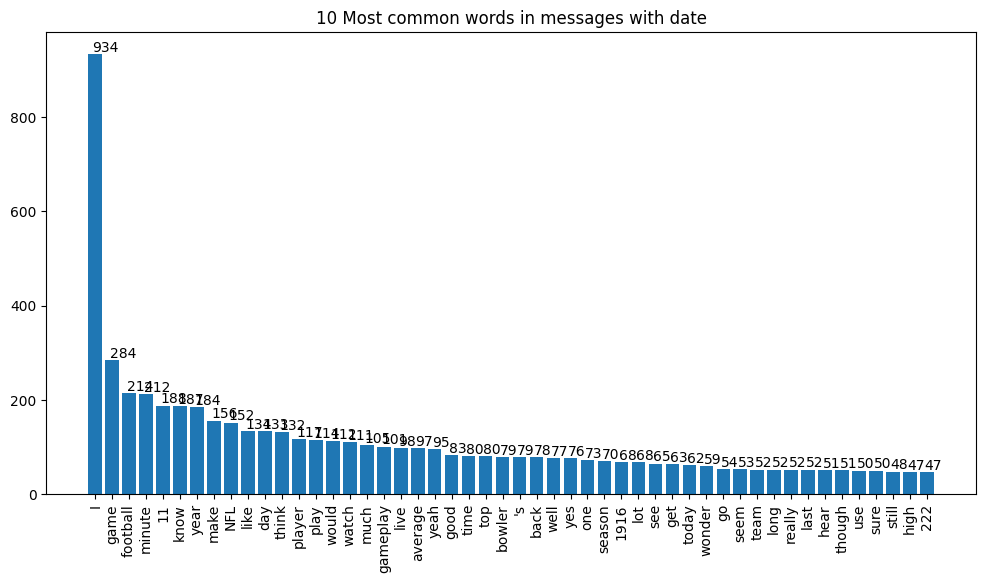

In [27]:
data = counter_words.most_common(50)
x = [x[0] for x in data]
y = [l[1] for l in data]
plt.figure(figsize=(12, 6))
plt.bar(x, y)
plt.xticks(rotation=90)
plt.title("10 Most common words in messages with date")
for i in range(len(x)):
  plt.text(i-0.15,y[i]+5,y[i])

Намечается явная проблема - датасет на одну тему получился - о спорте. Но какие то указатели, типа minute year day would time last уже есть в топе слов, что довольно отрадно. Постараемся еще проанализировать датасет - отвекторизуем его и посмотрим отображение с помощью t-SNE. Используем Bag of Words

In [21]:
model_bow = CountVectorizer()
X = model_bow.fit_transform(df_part["message_processed"].apply(lambda x: " ".join(x))).toarray()

In [22]:
X.shape

(1000, 2025)

Text(0.5, 1.0, 't-SNE representation of dataset')

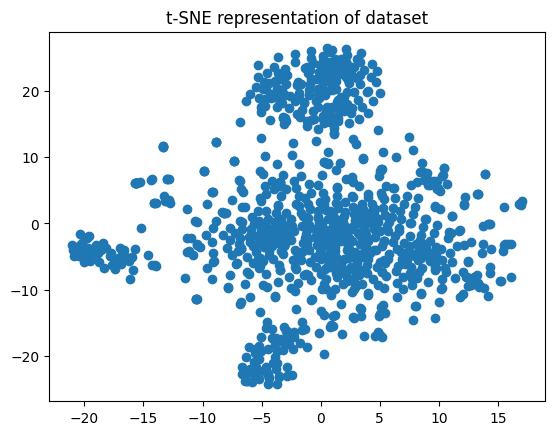

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE()
data = tsne.fit_transform(X)
plt.scatter(x=data[:, 0], y=data[:, 1])
plt.title("t-SNE representation of dataset")

На графике видим, что алгоритм разделил только по датасетам, что очень печально

## Word2vec

In [ ]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
import gensim.downloader
model = Word2Vec(common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [ ]:
glove_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
glove_vectors.get_vector("plan")

array([ 0.47415 ,  0.93673 , -0.62139 , -0.013054,  0.98956 ,  0.45873 ,
       -0.02254 ,  0.6956  ,  0.44207 , -0.44703 ,  0.33811 , -0.92783 ,
       -3.6716  ,  0.84413 ,  1.1669  ,  0.50926 ,  0.73615 ,  0.10636 ,
       -0.24516 , -1.0525  ,  0.44059 , -0.86163 , -0.39066 , -0.075361,
        0.029276], dtype=float32)

In [ ]:
glove_vectors.most_similar("plan")

[('media', 0.8908759951591492),
 ('personal', 0.8748670816421509),
 ('control', 0.8535847663879395),
 ('idea', 0.8530606031417847),
 ('general', 0.852401614189148),
 ('debate', 0.8438900709152222),
 ('social', 0.842548131942749),
 ('sales', 0.8322349190711975),
 ('service', 0.8312507271766663),
 ('resume', 0.8249419927597046)]

Bad pipe message: %s [b'8?$\x8e\xde\xf3Z\t\x8c\xb6\xa9\x14\x93\xff\xd0\xf1Q\x94 \xca\x88\xfeK\xb8\xc6\xc7\xe8e\x9dI\xa7\xc4[\xc54\xb9\xcbG<\xf4\x17\x1f6c\xbfu\xd9\xf8\x88\x84\xdf\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00', b'\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08']
Bad pipe message: %s [b'\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b'\xd3u\x83\x94\xc4\x97\x8a\x08&\x8f\x84Z\x14=\xfdM\x0ct \xbbY\xf3\x0eB\xda\x976\xab\x11D\xe2\xc0\x0fY\xab\xd9\xd2a5:\x17\xa1\x94rL(\x93o\xfb\x84\x91\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03']
Bad pipe message: %s [b'\xe